# QC stats

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
FIGOUTDIR = '../output/figures/0_Preimplantation.QC.part1.sample_filtering/'

In [4]:
! mkdir -p $FIGOUTDIR || true;

In [5]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'
THRESHFN = '../../combining_all_data/metadata/FR230814.DamID_thresholds.tsv'

## Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select conditions of interest
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[~anno['treatment'].isin(['alpha-amanitin'])]
anno = anno[anno.cellcount == 1]

# setting stage order
anno['stage_order'] = anno['stage'].apply(func=lambda s: {stage: i for i, stage in enumerate(stage_order)}[s])
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
anno = anno.set_index(anno['damid_name'])

# group data into different datasets
anno['dataset'] = 'other'
ind = (anno.genotype == 'C57BL/6J_x_JF1/Ms') #& (anno.fusion_construct == 'Dam-Lmnb1')
anno.loc[ind, 'dataset'] = 'EED_experiment'
ind = (anno.genotype.isin(['homozygous', '129S1/SvImJ_x_CAST/EiJ'])) & (anno.treatment == 'no_treatment')
anno.loc[ind, 'dataset'] = 'homozygous_embryo'
ind = (anno.genotype == 'homozygous') & (anno.treatment.isin(['Cbx7(CD)-Lap2b', 'Lap2b', 'Cbx7(CD)-Emd', 'Emd', 'Cbx7(CD)-Lbr']))
anno.loc[ind, 'dataset'] = 'homozygous_Cbx7-Lap2b'
ind = (anno.genotype == 'CBAB6F1_x_CAST/EiJ') & (anno.treatment == 'no_treatment')
anno.loc[ind, 'dataset'] = 'hybrid_embryo'
ind = (anno.genotype == 'CBAB6F1_x_CAST/EiJ') & (anno.treatment.isin(['Cbx7(CD)-Lap2b', 'Lap2b']))
anno.loc[ind, 'dataset'] = 'hybrid_Cbx7-Lap2b'
ind = (anno.fusion_construct != 'Dam-Lmnb1') & (anno.genotype == 'homozygous') & (anno.treatment == 'no_treatment')
anno.loc[ind, 'dataset'] = 'additional_constructs'
# ind = ~anno.treatment.isin(['no_treatment', 'EED_mKO', 'EED_ctrl'])
# anno.loc[ind, 'dataset'] = 'additional_treatments'

anno.head()

,runid,illumina_index,damid2_adapter_number,celseq2_adapter_number,cellcount,construct,fusion_construct,stage,treatment,genotype,...,nTranscripts_maternal,nTranscripts_paternal,allelic_celseq_balance,nERCC,nMito,DamID_PASS,DamID_PASS_allelic,CELseq_PASS,stage_order,dataset
damid_name,,,,,,,,,,,,,,,,,,,,,
KIN1971.index03.DamID2_BC_001,KIN1971,3,1,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,NaN,NaN,NaN,0,0,True,True,False,1,homozygous_embryo
KIN1971.index03.DamID2_BC_009,KIN1971,3,9,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,NaN,NaN,NaN,0,0,True,True,False,1,homozygous_embryo
KIN1971.index03.DamID2_BC_017,KIN1971,3,17,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,NaN,NaN,NaN,0,0,True,True,False,1,homozygous_embryo
KIN1971.index03.DamID2_BC_025,KIN1971,3,25,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,NaN,NaN,NaN,0,0,True,True,False,1,homozygous_embryo
KIN1971.index03.DamID2_BC_033,KIN1971,3,33,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,NaN,NaN,NaN,0,0,True,True,False,1,homozygous_embryo


In [8]:
tmp = anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'DamID_PASS', 'CELseq_PASS']).size()
tmp[tmp>0]

fusion_construct  stage  genotype           treatment     DamID_PASS  CELseq_PASS
Cbx1(FL)-Dam      2cell  homozygous         no_treatment  False       False            2
                                                                      True           116
                                                          True        True            27
Dam-Cbx1(CD)      2cell  C57BL/6J_x_JF1/Ms  EED_ctrl      False       False           28
                                                                      True            84
                                                                                    ... 
Dam-only          2cell  homozygous         Lap2b         True        True            12
                                            no_treatment  False       False           39
                                                                      True           120
                                                          True        False           31
                            

## Loading plotting colors

In [9]:
color_dict = ld.load_color_dict(COLORFN)

## Loading thresholds

In [10]:
thresholds = pd.read_table(THRESHFN)
thresholds

,fusion_construct,stage,genotype,depth_threshold,allelic_depth_threshold,ic_threshold
0,Dam-Lmnb1,zygote,homozygous,3000,0,1.4
1,Dam-Lmnb1,2cell,homozygous,10000,0,1.4
2,Dam-Lmnb1,8cell,homozygous,10000,0,1.4
3,Dam-Lmnb1,zygote,CBAB6F1_x_CAST/EiJ,3000,3000,1.4
4,Dam-Lmnb1,2cell,CBAB6F1_x_CAST/EiJ,10000,10000,1.4
5,Dam-Lmnb1,2cell,C57BL/6J_x_JF1/Ms,10000,10000,1.4
6,Dam-Lmnb1,8cell,CBAB6F1_x_CAST/EiJ,10000,10000,1.4
7,Dam-Lmnb1,mESC,129S1/SvImJ_x_CAST/EiJ,10000,10000,1.4
8,Dam-Lmnb1,morula,CAGGDamLMNB1_x_CAGGCRE,10000,0,1.4
9,Dam-Lmnb1,morula,CAGGDamLMNB1_x_Rosa26CAGGCRE,10000,0,1.4


# 1. DamID data filtering

In [11]:
anno[anno.dataset=='additional_treatments'].groupby(['fusion_construct', 'stage', 'genotype', 'treatment']).size()

Series([], dtype: int64)

In [12]:
df = anno.groupby(['dataset', 'fusion_construct', 'stage', 'genotype', 'treatment']).size()
df[df>0]

dataset                fusion_construct    stage   genotype                treatment     
EED_experiment         Dam-Cbx1(CD)        2cell   C57BL/6J_x_JF1/Ms       EED_ctrl          118
                                                                           EED_mKO           110
                       Dam-Lmnb1           2cell   C57BL/6J_x_JF1/Ms       EED_ctrl          301
                                                                           EED_mKO           225
additional_constructs  Cbx1(FL)-Dam        2cell   homozygous              no_treatment      145
                       Dam-Cbx1(CD)        2cell   homozygous              no_treatment      121
                       Dam-aH3K27me3       2cell   homozygous              no_treatment       81
                       Dam-aH3K27me3(mut)  2cell   homozygous              no_treatment      115
                       Dam-only            2cell   homozygous              no_treatment      236
homozygous_Cbx7-Lap2b  Dam-Lmnb1     

In [13]:
dataset_x_grouper = {
    'homozygous_embryo': 'stage',
    'additional_constructs': 'fusion_construct',
    'hybrid_embryo': 'stage',
    'EED_experiment': 'fusion_construct',
    'additional_treatments': 'treatment',
    'homozygous_Cbx7-Lap2b': 'fusion_construct',
    'hybrid_Cbx7-Lap2b': 'stage',
}

dataset_hue_grouper = {
    'homozygous_embryo': 'stage',
    'additional_constructs': 'fusion_construct',
    'hybrid_embryo': 'stage',
    'EED_experiment': 'treatment',
    'additional_treatments': 'treatment',
    'homozygous_Cbx7-Lap2b': 'treatment',
    'hybrid_Cbx7-Lap2b': 'treatment',
}

dataset_grouporder = {
    'homozygous_embryo': stage_order,
    'additional_constructs': ['Dam-only', 'Dam-Cbx1(CD)', 'Cbx1(FL)-Dam', 'Dam-aH3K27me3', 'Dam-aH3K27me3(mut)'],
    'hybrid_embryo': ['zygote', '2cell', '8cell'],
    'EED_experiment': ['Dam-Lmnb1', 'Dam-Cbx1(CD)'],
    'additional_treatments': ['Cbx7(CD)-Emd', 'Cbx7(CD)-Lap2b', 'Cbx7(CD)-Lbr', 'alpha-amanitin'],
    'homozygous_Cbx7-Lap2b': ['Dam-Lmnb1', 'Dam-aH3K27me3', 'Dam-only'],
    'hybrid_Cbx7-Lap2b': ['2cell', '8cell']
}

## 1.1 DamID filtering on depth

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1256074690.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1256074690.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1256074690.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1256074690.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1256074690.py:41: UserWarning: 

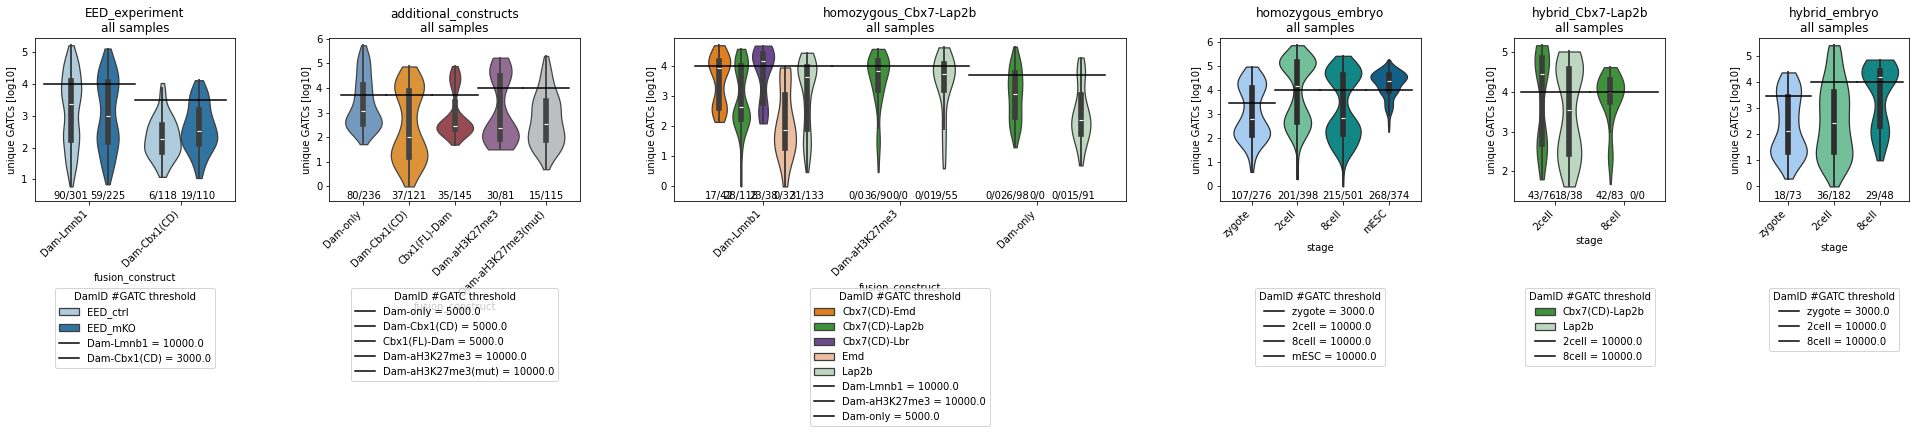

In [14]:
g_anno = anno[anno.dataset!='other'].groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title('%s\nall samples' % dataset)
    
    groupcol_x = dataset_x_grouper[dataset]
    groupcol_hue = dataset_hue_grouper[dataset]
    grouporder = dataset_grouporder[dataset]
    hue_order = annodf[groupcol_hue].sort_values().unique()
    
    for other_col in ['fusion_construct', 'genotype', 'stage', 'treatment']:
        if other_col in [groupcol_x, groupcol_hue]:
            continue
        ls1 = annodf.groupby([groupcol_x, groupcol_hue]).size()
        ls1 = ls1[ls1>0]
        ls2 = annodf.groupby([groupcol_x, groupcol_hue, other_col]).size()
        ls2 = ls2[ls2>0]
        assert len(ls1) == len(ls2)

    sns.violinplot(
        x = annodf[groupcol_x],
        y = np.log10(annodf['unique_damid_counts'] + 1),
        hue = annodf[groupcol_hue],
        palette=color_dict[groupcol_hue],
        ax = ax,
        order = grouporder,
        hue_order = hue_order,
        dodge = (groupcol_x != groupcol_hue),
        cut = 0
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('unique GATCs [log10]')
    
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    ymin = ylim[0] - 0.05*yrange
    ax.set_ylim(ymin, ylim[1])
    
    for x, cat in enumerate(grouporder):
        ind = annodf[groupcol_x] == cat
        c = annodf.loc[ind,'fusion_construct'].unique()
        s = annodf.loc[ind,'stage'].unique()
        g = annodf.loc[ind,'genotype'].unique()
        assert len(c) == 1, c
        assert len(s) == 1, s
        assert len(g) == 1, g
        
        # plot threshold line
        ind2 = (thresholds.fusion_construct==c[0]) & (thresholds.stage == s[0]) & (thresholds.genotype == g[0])
        T = thresholds.loc[ind2, 'depth_threshold'].values[0]
        ax.plot([x-.5, x+.5], [np.log10(T), np.log10(T)], c='k', label='%s = %.1f' % (cat, T))
        
        # plot number of cells passing depth threshold
        if groupcol_x == groupcol_hue:
            d = annodf.loc[ind,'unique_damid_counts']
            txt = '%d/%d' % ((d >= T).sum(), len(d))
            ax.text(x, ymin, txt, va='bottom', ha='center')
        else:
            n = len(hue_order)
            viol_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
            for i, cat2 in enumerate(hue_order):
                d = annodf.loc[ind & (annodf[groupcol_hue]==cat2), 'unique_damid_counts']
                txt = '%d/%d' % ((d >= T).sum(), len(d))
                dx = viol_locs[i]
                ax.text(x+dx, ymin, txt, va='bottom', ha='center')
        
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='DamID #GATC threshold')
    
outfn = FIGOUTDIR + 'DamID_filtering.1.filtering_on_depth.all_samples.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 1.2 DamID filtering on allelic balance

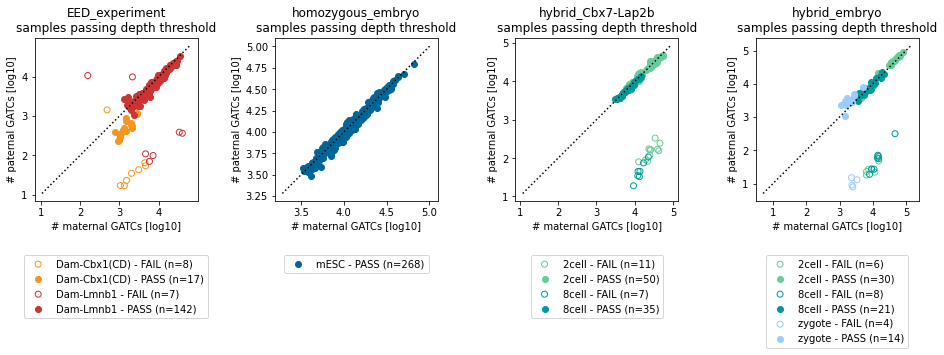

In [15]:
g_anno = anno[anno.is_heterozygous].groupby('dataset')
ncol = len(list(g_anno))
fig, axes = plt.subplots(1, ncol, figsize=(ncol*4, 3))
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title('%s\nsamples passing depth threshold' % dataset)
    
    annodf = annodf.copy()
    annodf = annodf[annodf.is_heterozygous]
    if len(annodf) == 0:
        continue
    
    ## only retain samples passing depth threshold
    annodf = annodf.merge(thresholds)
    ind0 = annodf.unique_damid_counts >= annodf['depth_threshold']
    ind1 = annodf.IC_mappability >= annodf.ic_threshold
    annodf = annodf[ind0]
    
    groupcol = dataset_x_grouper[dataset]
    grouporder = dataset_grouporder[dataset]

    for cat, df in annodf.groupby([groupcol, 'allelic_damid_balance']):
        clr = color_dict[groupcol][cat[0]]
        X = np.log10(df['maternal_damid_counts'] + 1)
        Y = np.log10(df['paternal_damid_counts'] + 1)
        
        lab = '%s - %s (n=%d)' % (cat[0], {True: 'PASS', False: 'FAIL'}[cat[1]], len(df))
        
        if cat[1]:
            ax.scatter(X, Y, c=clr, label=lab)
        else:
            ax.scatter(X, Y, facecolors='none', label=lab, edgecolors=clr)
        
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.3))
    
    a = np.log10(min(annodf['maternal_damid_counts'].min(), annodf['paternal_damid_counts'].min()) + 1) - .2
    b = np.log10(max(annodf['maternal_damid_counts'].max(), annodf['paternal_damid_counts'].max()) + 1) + .2
    ax.plot([a,b], [a,b], c='k', ls=':')
    ax.set_aspect('equal')
    ax.set_xlabel('# maternal GATCs [log10]')
    ax.set_ylabel('# paternal GATCs [log10]')

outfn = FIGOUTDIR + 'DamID_filtering.2.filtering_on_allelic_balance.samples_passing_damid_counts_and_ic_thresh.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 1.3 DamID filtering on IC

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/778626208.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/778626208.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/778626208.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/778626208.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/778626208.py:48: UserWarning: Fixed

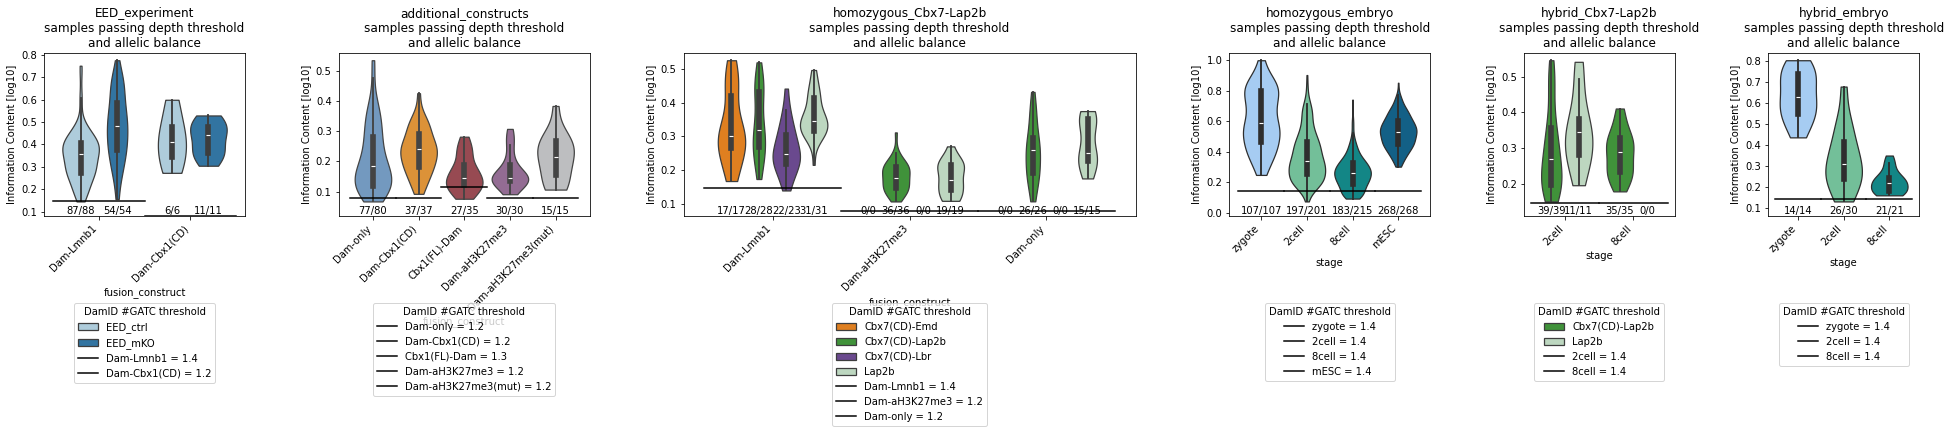

In [16]:
g_anno = anno[anno.dataset!='other'].groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title('%s\nsamples passing depth threshold\nand allelic balance' % dataset)
    
    ## only retain samples passing depth threshold
    annodf = annodf.copy()
    annodf = annodf.merge(thresholds)
    annodf['pass_depth'] = annodf.unique_damid_counts >= annodf['depth_threshold']
    annodf = annodf[annodf.pass_depth & annodf.allelic_damid_balance]
    
    # select grouping features
    groupcol_x = dataset_x_grouper[dataset]
    groupcol_hue = dataset_hue_grouper[dataset]
    grouporder = dataset_grouporder[dataset]
    hue_order = annodf[groupcol_hue].sort_values().unique()
    
    for other_col in ['fusion_construct', 'genotype', 'stage', 'treatment']:
        if other_col in [groupcol_x, groupcol_hue]:
            continue
        ls1 = annodf.groupby([groupcol_x, groupcol_hue]).size()
        ls1 = ls1[ls1>0]
        ls2 = annodf.groupby([groupcol_x, groupcol_hue, other_col]).size()
        ls2 = ls2[ls2>0]
        assert len(ls1) == len(ls2)

    sns.violinplot(
        x = annodf[groupcol_x],
        y = np.log10(annodf['IC_mappability']),
        hue = annodf[groupcol_hue],
        palette=color_dict[groupcol_hue],
        ax = ax,
        order = grouporder,
        hue_order = hue_order,
        dodge = (groupcol_x != groupcol_hue),
        cut = 0
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Information Content [log10]')
    
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    ymin = ylim[0] - 0.05*yrange
    ax.set_ylim(ymin, ylim[1])
    
    for x, cat in enumerate(grouporder):
        
        ind = annodf[groupcol_x] == cat
        c = annodf.loc[ind,'fusion_construct'].unique()
        s = annodf.loc[ind,'stage'].unique()
        g = annodf.loc[ind,'genotype'].unique()
        assert len(c) == 1, c
        assert len(s) == 1, s
        assert len(g) == 1, g
        
        # plot threshold line
        ind2 = (thresholds.fusion_construct==c[0]) & (thresholds.stage == s[0]) & (thresholds.genotype == g[0])
        T = thresholds.loc[ind2, 'ic_threshold'].values[0]
        ax.plot([x-.5, x+.5], [np.log10(T), np.log10(T)], c='k', label='%s = %.1f' % (cat, T))
        
        # plot number of cells passing depth threshold
        if groupcol_x == groupcol_hue:
            d = annodf.loc[ind,'IC_mappability']
            txt = '%d/%d' % ((d >= T).sum(), len(d))
            ax.text(x, ymin, txt, va='bottom', ha='center')
        else:
            n = len(hue_order)
            viol_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
            for i, cat2 in enumerate(hue_order):
                d = annodf.loc[ind & (annodf[groupcol_hue]==cat2), 'IC_mappability']
                txt = '%d/%d' % ((d >= T).sum(), len(d))
                dx = viol_locs[i]
                ax.text(x+dx, ymin, txt, va='bottom', ha='center')
        
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='DamID #GATC threshold')
    
outfn = FIGOUTDIR + 'DamID_filtering.3.filtering_on_IC.samples_passing_depth_thresh.pdf'
plt.savefig(outfn, bbox_inches='tight')

# 2. CELseq filtering

In [14]:
CS_DEPTH_THRESHOLD = 3000
CS_PCT_ERCC_THRESHOLD = 0.5
CS_PCT_MITO_THRESHOLD = 15

## 2.1 Number of transcripts

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1926728916.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1926728916.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1926728916.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1926728916.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/1926728916.py:42: UserWarning: 

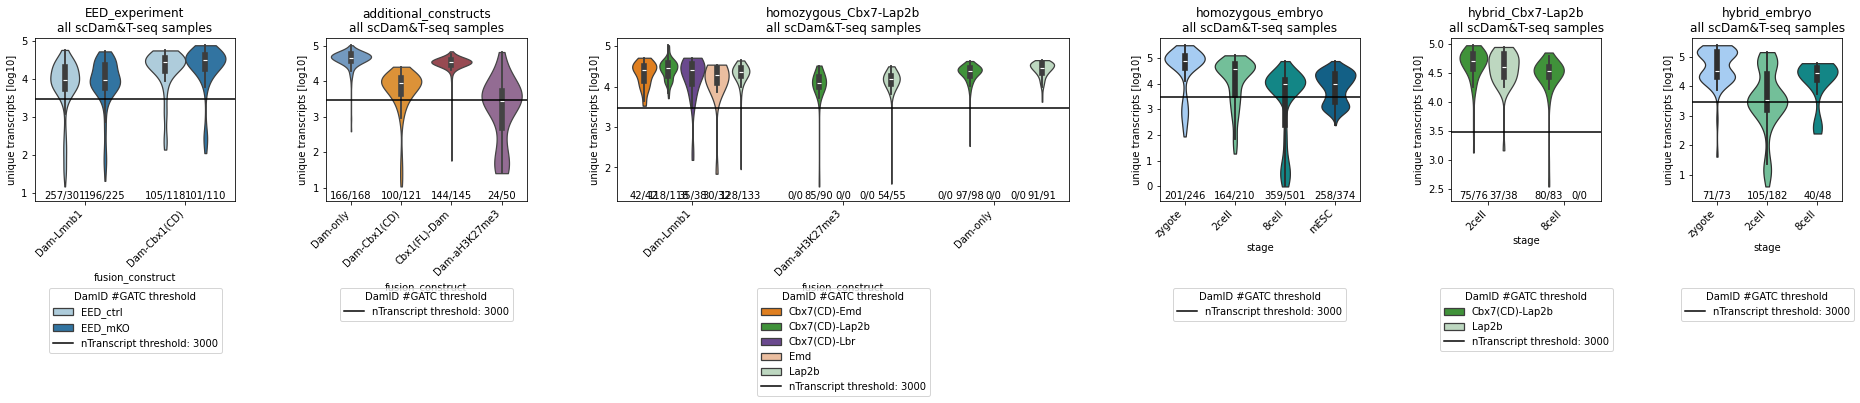

In [18]:
g_anno = anno[(anno.technique=='DamIDnT')&(anno.dataset!='other')].groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title('%s\nall scDam&T-seq samples' % dataset)
    
    groupcol_x = dataset_x_grouper[dataset]
    groupcol_hue = dataset_hue_grouper[dataset]
    grouporder = np.array(dataset_grouporder[dataset])
    grouporder = grouporder[np.isin(grouporder, annodf[groupcol_x].unique())]
    hue_order = annodf[groupcol_hue].sort_values().unique()
    
    for other_col in ['fusion_construct', 'genotype', 'stage', 'treatment']:
        if other_col in [groupcol_x, groupcol_hue]:
            continue
        ls1 = annodf.groupby([groupcol_x, groupcol_hue]).size()
        ls1 = ls1[ls1>0]
        ls2 = annodf.groupby([groupcol_x, groupcol_hue, other_col]).size()
        ls2 = ls2[ls2>0]
        assert len(ls1) == len(ls2)

    sns.violinplot(
        x = annodf[groupcol_x],
        y = np.log10(annodf['nTranscripts'] + 1),
        hue = annodf[groupcol_hue],
        palette=color_dict[groupcol_hue],
        ax = ax,
        order = grouporder,
        hue_order = hue_order,
        dodge = (groupcol_x != groupcol_hue),
        cut = 0
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('unique transcripts [log10]')
    
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    ymin = ylim[0] - 0.05*yrange
    ax.set_ylim(ymin, ylim[1])
    
    for x, cat in enumerate(grouporder):
        ind = annodf[groupcol_x] == cat
        c = annodf.loc[ind,'fusion_construct'].unique()
        s = annodf.loc[ind,'stage'].unique()
        g = annodf.loc[ind,'genotype'].unique()
        assert len(c) < 2, c
        assert len(s) < 2, s
        assert len(g) < 2, g
        
        # plot number of cells passing depth threshold
        if groupcol_x == groupcol_hue:
            d = annodf.loc[ind,'nTranscripts']
            txt = '%d/%d' % ((d >= CS_DEPTH_THRESHOLD).sum(), len(d))
            ax.text(x, ymin, txt, va='bottom', ha='center')
        else:
            n = len(hue_order)
            viol_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
            for i, cat2 in enumerate(hue_order):
                d = annodf.loc[ind & (annodf[groupcol_hue]==cat2), 'nTranscripts']
                txt = '%d/%d' % ((d >= CS_DEPTH_THRESHOLD).sum(), len(d))
                dx = viol_locs[i]
                ax.text(x+dx, ymin, txt, va='bottom', ha='center')
    
    ax.axhline(np.log10(CS_DEPTH_THRESHOLD+1), c='k', label='nTranscript threshold: %d' % CS_DEPTH_THRESHOLD)
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='DamID #GATC threshold')
    
outfn = FIGOUTDIR + 'CELseq_filtering.1.filtering_on_nTranscripts.all_DamnT_samples.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 2.2 Percent Mitochondrial transcripts

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2010049995.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2010049995.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


Dam-Lmnb1 EED_ctrl 241
Dam-Lmnb1 EED_mKO 180
Dam-Cbx1(CD) EED_ctrl 101
Dam-Cbx1(CD) EED_mKO 98


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2010049995.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2010049995.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


Dam-Lmnb1 Cbx7(CD)-Emd 40
Dam-Lmnb1 Cbx7(CD)-Lap2b 118
Dam-Lmnb1 Cbx7(CD)-Lbr 34
Dam-Lmnb1 Emd 29
Dam-Lmnb1 Lap2b 125
Dam-aH3K27me3 Cbx7(CD)-Emd 0
Dam-aH3K27me3 Cbx7(CD)-Lap2b 84
Dam-aH3K27me3 Cbx7(CD)-Lbr 0
Dam-aH3K27me3 Emd 0
Dam-aH3K27me3 Lap2b 54
Dam-only Cbx7(CD)-Emd 0
Dam-only Cbx7(CD)-Lap2b 93
Dam-only Cbx7(CD)-Lbr 0
Dam-only Emd 0
Dam-only Lap2b 84


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2010049995.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2010049995.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


2cell Cbx7(CD)-Lap2b 73
2cell Lap2b 37
8cell Cbx7(CD)-Lap2b 78
8cell Lap2b 0


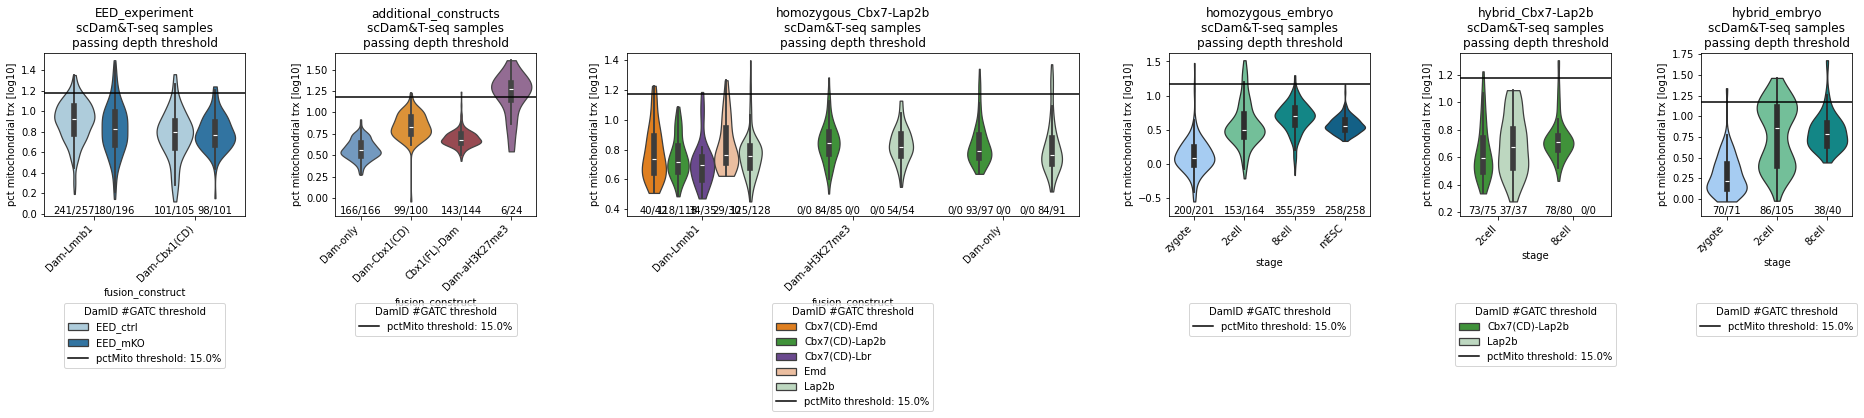

In [19]:
g_anno = anno[(anno.technique=='DamIDnT')&(anno.dataset!='other')].groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title('%s\nscDam&T-seq samples\npassing depth threshold' % dataset)
    
    annodf = annodf[annodf.nTranscripts >= CS_DEPTH_THRESHOLD]
    
    groupcol_x = dataset_x_grouper[dataset]
    groupcol_hue = dataset_hue_grouper[dataset]
    grouporder = np.array(dataset_grouporder[dataset])
    grouporder = grouporder[np.isin(grouporder, annodf[groupcol_x].unique())]
    hue_order = annodf[groupcol_hue].sort_values().unique()
    
    for other_col in ['fusion_construct', 'genotype', 'stage', 'treatment']:
        if other_col in [groupcol_x, groupcol_hue]:
            continue
        ls1 = annodf.groupby([groupcol_x, groupcol_hue]).size()
        ls1 = ls1[ls1>0]
        ls2 = annodf.groupby([groupcol_x, groupcol_hue, other_col]).size()
        ls2 = ls2[ls2>0]
        assert len(ls1) == len(ls2)

    sns.violinplot(
        x = annodf[groupcol_x],
        y = np.log10((annodf['nMito'])/annodf['nTranscripts']*100),
        hue = annodf[groupcol_hue],
        palette=color_dict[groupcol_hue],
        ax = ax,
        order = grouporder,
        hue_order = hue_order,
        dodge = (groupcol_x != groupcol_hue),
        cut = 0
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('pct mitochondrial trx [log10]')
    
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    ymin = ylim[0] - 0.05*yrange
    ymax = max(ylim[1], np.log10(CS_PCT_MITO_THRESHOLD+.1))
    ax.set_ylim(ymin, ymax)
    
    for x, cat in enumerate(grouporder):
        ind = annodf[groupcol_x] == cat
        c = annodf.loc[ind,'fusion_construct'].unique()
        s = annodf.loc[ind,'stage'].unique()
        g = annodf.loc[ind,'genotype'].unique()
        assert len(c) < 2, c
        assert len(s) < 2, s
        assert len(g) < 2, g
        
        # plot number of cells passing depth threshold
        if groupcol_x == groupcol_hue:
            d = annodf.loc[ind,'nMito']/annodf.loc[ind,'nTranscripts']*100
            txt = '%d/%d' % ((d < CS_PCT_MITO_THRESHOLD).sum(), len(d))
            ax.text(x, ymin, txt, va='bottom', ha='center')
        else:
            n = len(hue_order)
            viol_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
            for i, cat2 in enumerate(hue_order):
                ind2 = ind & (annodf[groupcol_hue]==cat2)
                d = annodf.loc[ind2, 'nMito']/annodf.loc[ind2, 'nTranscripts']*100
                print(cat, cat2, (d < CS_PCT_MITO_THRESHOLD).sum())
                txt = '%d/%d' % ((d < CS_PCT_MITO_THRESHOLD).sum(), len(d))
                dx = viol_locs[i]
                ax.text(x+dx, ymin, txt, va='bottom', ha='center')
    
    ax.axhline(np.log10(CS_PCT_MITO_THRESHOLD), c='k', label='pctMito threshold: {:.1f}%'.format(CS_PCT_MITO_THRESHOLD))
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='DamID #GATC threshold')
    
outfn = FIGOUTDIR + 'CELseq_filtering.2.filtering_on_pctMito.DamnT_samples_passing_depth_thresh.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 2.3 Percent ERCC transcripts

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/3750329608.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/3750329608.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/3750329608.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/3750329608.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/3750329608.py:44: UserWarning: 

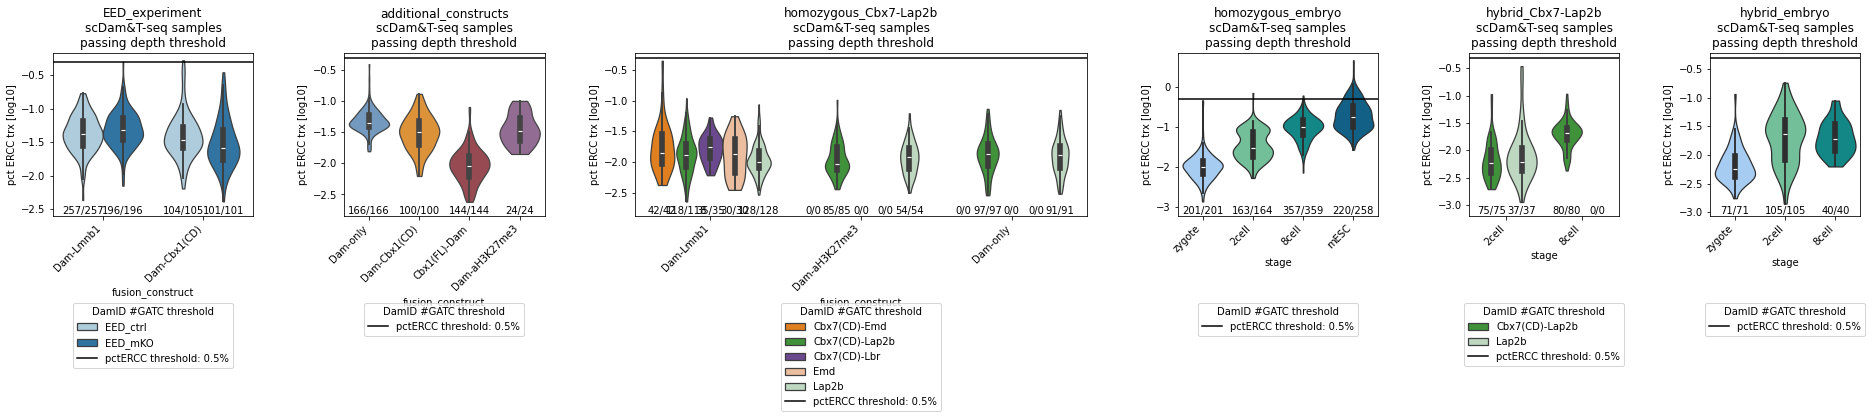

In [20]:
g_anno = anno[(anno.technique=='DamIDnT')&(anno.dataset!='other')].groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title('%s\nscDam&T-seq samples\npassing depth threshold' % dataset)
    
    annodf = annodf[annodf.nTranscripts >= CS_DEPTH_THRESHOLD]
    
    groupcol_x = dataset_x_grouper[dataset]
    groupcol_hue = dataset_hue_grouper[dataset]
    grouporder = np.array(dataset_grouporder[dataset])
    grouporder = grouporder[np.isin(grouporder, annodf[groupcol_x].unique())]
    hue_order = annodf[groupcol_hue].sort_values().unique()
    
    for other_col in ['fusion_construct', 'genotype', 'stage', 'treatment']:
        if other_col in [groupcol_x, groupcol_hue]:
            continue
        ls1 = annodf.groupby([groupcol_x, groupcol_hue]).size()
        ls1 = ls1[ls1>0]
        ls2 = annodf.groupby([groupcol_x, groupcol_hue, other_col]).size()
        ls2 = ls2[ls2>0]
        assert len(ls1) == len(ls2)

    sns.violinplot(
        x = annodf[groupcol_x],
        y = np.log10((annodf['nERCC']+1)/annodf['nTranscripts']*100),
        hue = annodf[groupcol_hue],
        palette=color_dict[groupcol_hue],
        ax = ax,
        order = grouporder,
        hue_order = hue_order,
        dodge = (groupcol_x != groupcol_hue),
        cut=0
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('pct ERCC trx [log10]')
    
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]
    ymin = ylim[0] - 0.05*yrange
    ymax = max(ylim[1], np.log10(CS_PCT_ERCC_THRESHOLD+.1))
    ax.set_ylim(ymin, ymax)
    
    for x, cat in enumerate(grouporder):
        ind = annodf[groupcol_x] == cat
        c = annodf.loc[ind,'fusion_construct'].unique()
        s = annodf.loc[ind,'stage'].unique()
        g = annodf.loc[ind,'genotype'].unique()
        assert len(c) < 2, c
        assert len(s) < 2, s
        assert len(g) < 2, g
        
        # plot number of cells passing depth threshold
        if groupcol_x == groupcol_hue:
            d = annodf.loc[ind,'nERCC']/annodf.loc[ind,'nTranscripts']*100
            txt = '%d/%d' % ((d < CS_PCT_ERCC_THRESHOLD).sum(), len(d))
            ax.text(x, ymin, txt, va='bottom', ha='center')
        else:
            n = len(hue_order)
            viol_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
            for i, cat2 in enumerate(hue_order):
                ind2 = ind & (annodf[groupcol_hue]==cat2)
                d = annodf.loc[ind2, 'nERCC']/annodf.loc[ind2, 'nTranscripts']*100
                txt = '%d/%d' % ((d < CS_PCT_ERCC_THRESHOLD).sum(), len(d))
                dx = viol_locs[i]
                ax.text(x+dx, ymin, txt, va='bottom', ha='center')
    
    ax.axhline(np.log10(CS_PCT_ERCC_THRESHOLD), c='k', label='pctERCC threshold: {:.1f}%'.format(CS_PCT_ERCC_THRESHOLD))
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='DamID #GATC threshold')
    
outfn = FIGOUTDIR + 'CELseq_filtering.2.filtering_on_pctERCC.DamnT_samples_passing_depth_thresh.pdf'
plt.savefig(outfn, bbox_inches='tight')

# 3. Overview

## 3.1 Saving overview of samples with filtering parameters

In [15]:
to_save = anno.copy()
to_save = to_save.merge(thresholds.copy()).rename(columns={
    'depth_threshold': 'DamID_depth_thresh', 
    'ic_threshold': 'DamID_IC_thresh',
    'maternal_damid_counts': 'unique_damid_counts_mat',
    'paternal_damid_counts': 'unique_damid_counts_pat'
})
to_save['CELseq_depth_thresh'] = CS_DEPTH_THRESHOLD
to_save['CELseq_pctMito_thresh'] = CS_PCT_MITO_THRESHOLD
to_save['CELseq_pctERCC_thresh'] = CS_PCT_ERCC_THRESHOLD
to_save['pctMito'] = to_save['nMito'] / to_save['nTranscripts'] * 100
to_save['pctERCC'] = to_save['nERCC'] / to_save['nTranscripts'] * 100
to_save['unique_damid_counts'] = to_save['unique_damid_counts'].astype(int)
to_save['unique_damid_counts_mat'] = to_save['unique_damid_counts_mat'].fillna(0).astype(int)
to_save['unique_damid_counts_pat'] = to_save['unique_damid_counts_pat'].fillna(0).astype(int)

cols = [
    'damid_name', 'celseq_name', 'technique',
    'dataset', 'fusion_construct', 'stage', 'treatment', 'genotype', 'is_heterozygous',
    'unique_damid_counts', 'unique_damid_counts_mat', 'unique_damid_counts_pat',
    'IC_mappability', 'allelic_damid_balance', 
    'nGenes', 'nTranscripts', 'pctERCC', 'pctMito', 'allelic_celseq_balance',
    'DamID_depth_thresh', 'DamID_IC_thresh',
    'CELseq_depth_thresh', 'CELseq_pctMito_thresh', 'CELseq_pctERCC_thresh',
    'DamID_PASS', 'DamID_PASS_allelic', 'CELseq_PASS'
]

to_save = to_save[cols]

outfn = FIGOUTDIR + 'sample_overview_with_filtering_parameters.tsv'
to_save.to_csv(outfn, sep='\t', header=True, index=False)

## 3.2 Overview of DamID filtering steps

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/512630027.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/512630027.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/512630027.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/512630027.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/512630027.py:58: UserWarning: Fixed

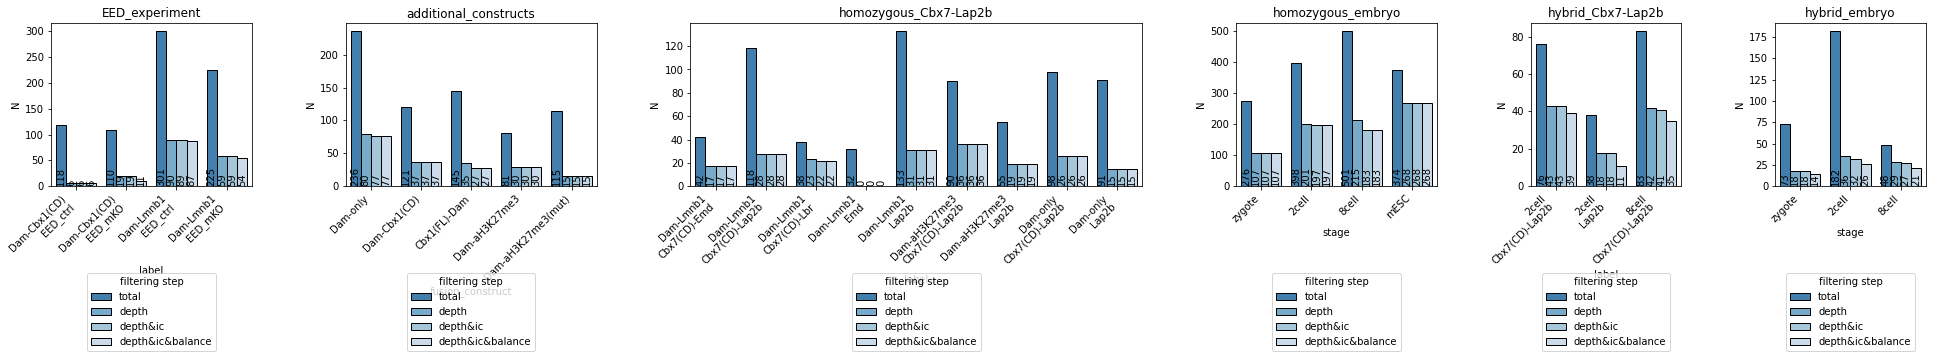

In [22]:
to_plot = to_save.copy()
to_plot['DamID_depth_pass'] = to_plot['unique_damid_counts'] >= to_plot['DamID_depth_thresh']
to_plot['DamID_IC_pass'] = to_plot['IC_mappability'] >= to_plot['DamID_IC_thresh']
to_plot['DamID_balance_pass'] = to_plot['allelic_damid_balance'].values
to_plot['depth'] = to_plot['DamID_depth_pass']
to_plot['depth&ic'] = to_plot['depth'] & to_plot['DamID_IC_pass']
to_plot['depth&ic&balance'] = to_plot['depth&ic'] & to_plot['DamID_balance_pass']

assert all(to_plot['depth&ic&balance'] == to_plot['DamID_PASS'])

cols = ['dataset', 'fusion_construct', 'stage', 'treatment', 'genotype']
tmp = to_plot.groupby(cols).size().reset_index().rename(columns={0:'total'})
to_plot = to_plot.groupby(cols).agg({'depth': sum, 'depth&ic': sum, 'depth&ic&balance': sum}).reset_index()
to_plot = to_plot.merge(tmp)

g_anno = to_plot.groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    annodf = annodf.copy()
    ax.set_title(dataset)
    
    groupcol1 = dataset_x_grouper[dataset]
    groupcol2 = dataset_hue_grouper[dataset]
    if groupcol1 != groupcol2:
        annodf['label'] = annodf.apply(axis = 1, func = lambda r: '%s\n%s' % (r[groupcol1], r[groupcol2]))
        grouporder = annodf.sort_values(by=[groupcol1, groupcol2])['label'].unique()
        groupcol = 'label'
        annodf = annodf.melt(id_vars=cols+['label'], var_name='filtering step', value_name='N')
    else:
        groupcol = groupcol1
        grouporder = dataset_grouporder[dataset]
        annodf = annodf.melt(id_vars=cols, var_name='filtering step', value_name='N')
    horder = ['total', 'depth', 'depth&ic', 'depth&ic&balance']
    
    annodf.copy()
    
    
    sns.barplot(
        x = annodf[groupcol],
        y = annodf['N'],
        hue = annodf['filtering step'],
        ax = ax,
        hue_order = horder,
        order = grouporder,
        palette='tab20c',
        edgecolor='k'
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    for x, cat in enumerate(grouporder):
        
        for xadj, step in enumerate(horder):
            
            xadj = {0: -.3, 1: -.1, 2: .1, 3: .3}[xadj]
            n = annodf.loc[(annodf[groupcol]==cat) & (annodf['filtering step'] == step), 'N'].values[0]
            txt = '%d' % n
            ax.text(x+xadj, 0, txt, rotation=90, ha='center', va='bottom')
        
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='filtering step')
    
outfn = FIGOUTDIR + 'DamID_filtering.4.progressive_filtering_steps.N_samples.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 3.3 Overview of CELseq filtering steps

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2142497150.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2142497150.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2142497150.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2142497150.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/2142497150.py:58: UserWarning: 

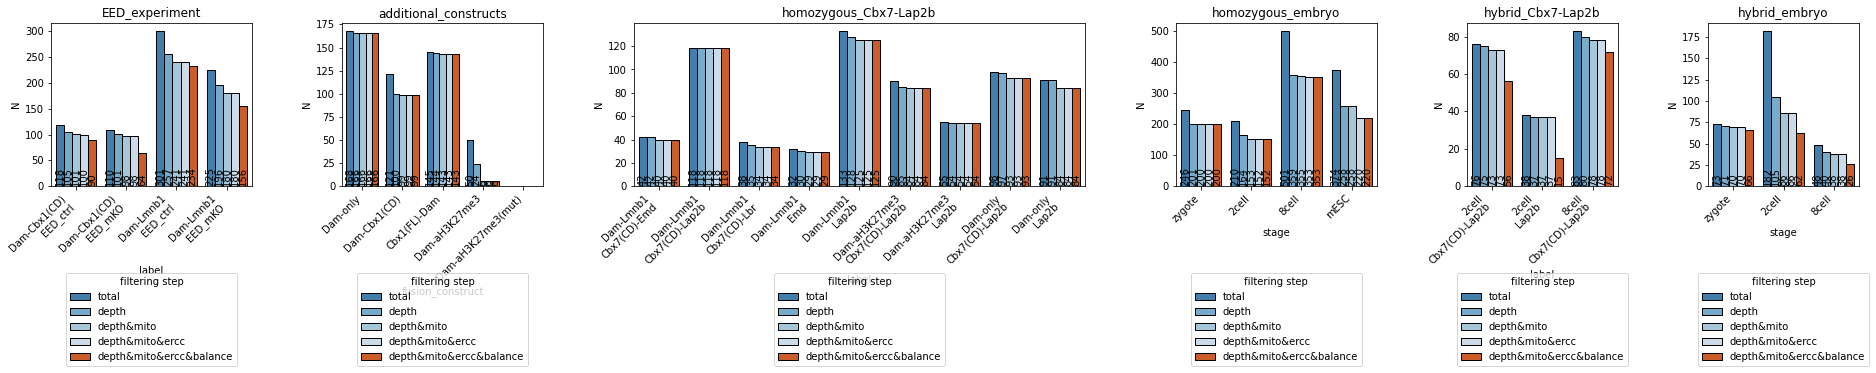

In [23]:
to_plot = to_save[(to_save.technique=='DamIDnT')].copy()
to_plot['CELseq_depth_pass'] = to_plot['nTranscripts'] >= to_plot['CELseq_depth_thresh']
to_plot['CELseq_mito_pass'] = to_plot['pctMito'] < to_plot['CELseq_pctMito_thresh']
to_plot['CELseq_ercc_pass'] = to_plot['pctERCC'] < to_plot['CELseq_pctERCC_thresh']
to_plot['depth'] = to_plot['CELseq_depth_pass']
to_plot['depth&mito'] = to_plot['depth'] & to_plot['CELseq_mito_pass']
to_plot['depth&mito&ercc'] = to_plot['depth&mito'] & to_plot['CELseq_ercc_pass']
to_plot['depth&mito&ercc&balance'] = to_plot['depth&mito&ercc'] & to_plot['allelic_celseq_balance'] & to_plot['allelic_damid_balance']


assert all(to_plot['depth&mito&ercc&balance'] == to_plot['CELseq_PASS'])

cols = ['dataset', 'fusion_construct', 'stage', 'treatment', 'genotype']
tmp = to_plot.groupby(cols).size().reset_index().rename(columns={0:'total'})
to_plot = to_plot.groupby(cols).agg({'depth': sum, 'depth&mito': sum, 'depth&mito&ercc': sum, 'depth&mito&ercc&balance': sum}).reset_index()
to_plot = to_plot.merge(tmp)

g_anno = to_plot.groupby('dataset')
wr = [sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0) for ds, df in g_anno]
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)*1.2, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title(dataset)
    
    horder = ['total', 'depth', 'depth&mito', 'depth&mito&ercc', 'depth&mito&ercc&balance']
    
    annodf.copy()
    groupcol1 = dataset_x_grouper[dataset]
    groupcol2 = dataset_hue_grouper[dataset]
    if groupcol1 != groupcol2:
        annodf['label'] = annodf.apply(axis = 1, func = lambda r: '%s\n%s' % (r[groupcol1], r[groupcol2]))
        grouporder = annodf.sort_values(by=[groupcol1, groupcol2])['label'].unique()
        groupcol = 'label'
        annodf = annodf.melt(id_vars=cols+['label'], var_name='filtering step', value_name='N')
    else:
        groupcol = groupcol1
        grouporder = dataset_grouporder[dataset]
        annodf = annodf.melt(id_vars=cols, var_name='filtering step', value_name='N')
    
    sns.barplot(
        x = annodf[groupcol],
        y = annodf['N'],
        hue = annodf['filtering step'],
        ax = ax,
        hue_order = horder,
        order = grouporder,
        palette='tab20c',
        edgecolor='k'
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    n = len(horder)
    bar_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
    for x, cat in enumerate(grouporder):
        
        for xadj, step in enumerate(horder):
            
            xadj = bar_locs[xadj]
            ind = (annodf[groupcol]==cat) & (annodf['filtering step'] == step)
            if ind.sum() == 0:
                continue
            n = annodf.loc[ind, 'N'].values[0]
            txt = '%d' % n
            ax.text(x+xadj, 0, txt, rotation=90, ha='center', va='bottom')
        
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='filtering step')
    
outfn = FIGOUTDIR + 'CELseq_filtering.4.progressive_filtering_steps.N_samples.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 3.2 Saving overview of filtering results

In [16]:
annodf = anno.copy()
annodf['DamID&CELseq_PASS'] = annodf.DamID_PASS & annodf.CELseq_PASS
annodf.loc[annodf.technique=='Damaris','technique'] = 'DamID'

cols = [
    'dataset', 'fusion_construct', 'stage', 'treatment', 'genotype', 'technique'
]
df0 = annodf.groupby(cols).size().reset_index().rename(columns={0:'total'})
df0 = df0[df0.total > 0]
df1 = annodf.groupby(cols).agg({'DamID_PASS': sum, 'CELseq_PASS': sum, 'DamID&CELseq_PASS': sum, 'DamID_PASS_allelic': sum}).reset_index()

to_save = df0.merge(df1)

outfn = FIGOUTDIR + 'overview_of_filtering_results.tsv'
to_save.to_csv(outfn, sep='\t', header=True, index=False)

EED_experiment 4 4
['DamIDnT:total' 'DamIDnT:DamID_PASS' 'DamIDnT:CELseq_PASS'
 'DamIDnT:DamID&CELseq_PASS']
additional_constructs 5 6
['DamIDnT:total' 'DamID:total' 'DamIDnT:DamID_PASS' 'DamID:DamID_PASS'
 'DamIDnT:CELseq_PASS' 'DamIDnT:DamID&CELseq_PASS']
homozygous_Cbx7-Lap2b 9 4
['DamIDnT:total' 'DamIDnT:DamID_PASS' 'DamIDnT:CELseq_PASS'
 'DamIDnT:DamID&CELseq_PASS']
homozygous_embryo 4 6
['DamID:total' 'DamIDnT:total' 'DamID:DamID_PASS' 'DamIDnT:DamID_PASS'
 'DamIDnT:CELseq_PASS' 'DamIDnT:DamID&CELseq_PASS']
hybrid_Cbx7-Lap2b 3 4
['DamIDnT:total' 'DamIDnT:DamID_PASS' 'DamIDnT:CELseq_PASS'
 'DamIDnT:DamID&CELseq_PASS']
hybrid_embryo 3 4
['DamIDnT:total' 'DamIDnT:DamID_PASS' 'DamIDnT:CELseq_PASS'
 'DamIDnT:DamID&CELseq_PASS']


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/4035390690.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/4035390690.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/4035390690.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/4035390690.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_12628/4035390690.py:59: UserWarning: 

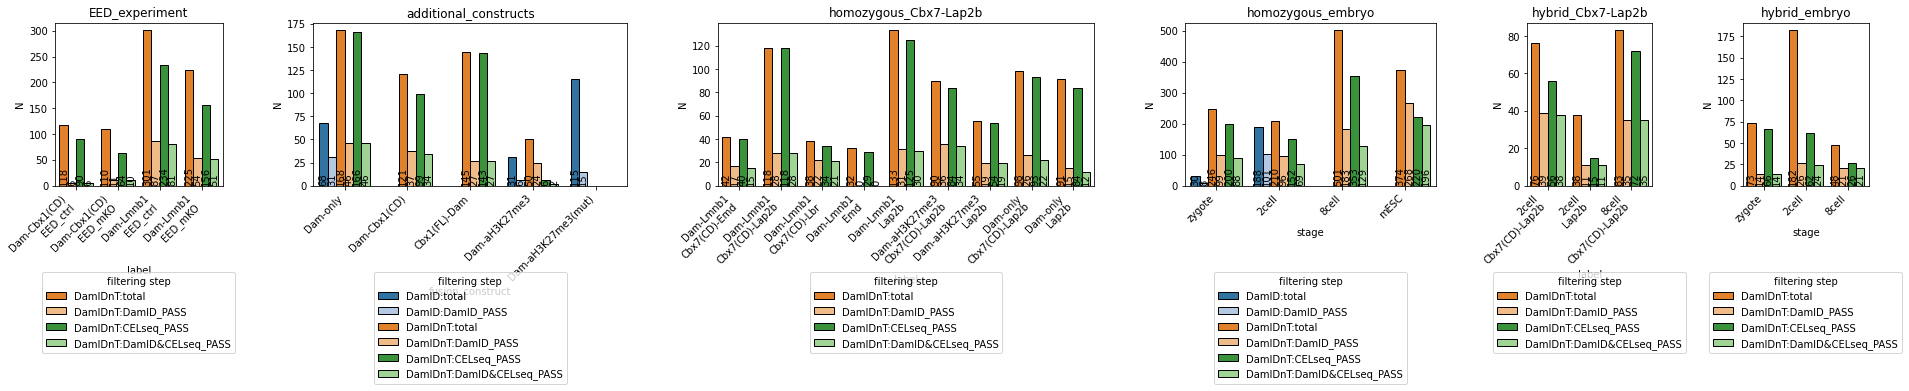

In [25]:
to_plot = to_save.copy()
to_plot.loc[to_plot.technique=='Damaris','technique'] = 'DamID'
to_plot = to_plot.melt(id_vars=cols, var_name='filtering', value_name='N')
to_plot['filt'] = to_plot.apply(axis=1, func = lambda r: '%s:%s' % (r['technique'], r['filtering']))
to_plot = to_plot[~to_plot.filt.isin(['DamID:CELseq_PASS', 'DamID:DamID&CELseq_PASS'])]
    
g_anno = to_plot.groupby('dataset')
wr = list()
for ds, df in g_anno:
    ngroups = sum(df.groupby([dataset_x_grouper[ds], dataset_hue_grouper[ds]]).size()>0)
    nfilt = len(df['filt'].unique())
    print(ds, ngroups, nfilt)
    print(df['filt'].unique())
    wr.append(ngroups*nfilt)
ncol = len(wr)
fig, axes = plt.subplots(1, ncol, figsize=(sum(wr)/4, 3), gridspec_kw={'width_ratios': wr})
plt.subplots_adjust(wspace=.4)
counter = 0

vals = [
    'DamID:total', 'DamID:DamID_PASS', 
    'DamIDnT:total', 'DamIDnT:DamID_PASS', 'DamIDnT:CELseq_PASS', 'DamIDnT:DamID&CELseq_PASS'
]
pal = {v: sns.color_palette('tab20', n_colors=20)[i] for i, v in enumerate(vals)}

for dataset, annodf in g_anno:
    
    ax = axes[counter]
    counter += 1
    
    ax.set_title(dataset)

    groupcol1 = dataset_x_grouper[dataset]
    groupcol2 = dataset_hue_grouper[dataset]
    if groupcol1 != groupcol2:
        annodf['label'] = annodf.apply(axis = 1, func = lambda r: '%s\n%s' % (r[groupcol1], r[groupcol2]))
        grouporder = annodf.sort_values(by=[groupcol1, groupcol2])['label'].unique()
        groupcol = 'label'
#         annodf = annodf.melt(id_vars=cols+['label'], var_name='filtering step', value_name='N')
    else:
        groupcol = groupcol1
        grouporder = dataset_grouporder[dataset]
#         annodf = annodf.melt(id_vars=cols, var_name='filtering step', value_name='N')

    horder = np.copy(np.array(vals))
    horder = horder[np.isin(horder, annodf['filt'].unique())]
    
    pl = sns.barplot(
        x = annodf[groupcol],
        y = annodf['N'],
        hue = annodf['filt'],
        ax = ax,
        hue_order = horder,
        order = grouporder,
        palette = pal,
        edgecolor='k'
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    n = len(horder)
    bar_locs = np.linspace(-0.4,0.4,n*2+1)[1::2]
    for x, cat in enumerate(grouporder):

        for xadj, step in enumerate(horder):
            
            pos = x + bar_locs[xadj]

            ind = (annodf[groupcol]==cat) & (annodf['filt'] == step)
            if ind.sum() == 0:
                continue
            n = annodf.loc[ind, 'N'].values[0]
            txt = '%d' % n
            ax.text(pos, 0, txt, rotation=90, ha='center', va='bottom')
        
    ax.legend(loc='upper center', bbox_to_anchor=(.5, -.5), title='filtering step')
    
outfn = FIGOUTDIR + 'total_filtering.DamID_and_CELseq_filtering.N_samples.pdf'
plt.savefig(outfn, bbox_inches='tight')

# 4. Borsos

In [26]:
FN = '../../GSE112551/metadata/FR200928.GSE112551.metadata.quality_stats.tsv'
borsos = pd.read_table(FN)
borsos.groupby(['fusion_construct', 'stage', 'cellcount', 'strain', 'treatment']).size()

fusion_construct  stage                cellcount  strain                          treatment     
Dam-LMNB1         2cell_embryo         1          C57BL_6NJ_female_x_CAST_male    no_treatment       47
                                       20         C57BL_6NJ_female_x_CAST_male    DMSO                2
                                                                                  aphidicolin         4
                                                                                  no_treatment        3
                                                  CAST_female_x_C57BL_6NJ_male    no_treatment        2
                  8cell_embryo         1          C57BL_6NJ_female_x_CAST_male    no_treatment       42
                                       24         C57BL_6NJ_female_x_CAST_male    no_treatment        3
                  GV_oocyte            1          C57BL_6NJ                       no_treatment      109
                                       20         C57BL_6NJ            

## 4.1 Comparison in sample number

In [27]:
borsos_sub = borsos.copy()
borsos_sub['stage'] = borsos_sub['stage'].apply(func = lambda s: s.replace('_embryo',''))
borsos_sub = borsos_sub[borsos_sub.cellcount == '1']
borsos_sub = borsos_sub[borsos_sub.treatment == 'no_treatment']
borsos_sub = borsos_sub[borsos_sub.stage.isin(['zygote', '2cell', '8cell', 'mESC'])]
borsos_sub = borsos_sub.rename(columns={'strain': 'genotype'})

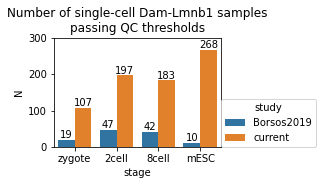

In [28]:
to_plot = borsos_sub.copy()
to_plot = to_plot.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']).size().reset_index().rename(columns={0: 'N'})
to_plot['study'] = 'Borsos2019'
to_plot = to_plot[to_plot.fusion_construct == 'Dam-LMNB1']

ind0 = (anno.genotype == 'homozygous') | (anno.stage == 'mESC')
ind1 = (anno.cellcount == 1) & anno.DamID_PASS
ind2 = anno.fusion_construct.isin(['Dam-Lmnb1']) & (anno.treatment == 'no_treatment')
tmp = anno[ind0&ind1&ind2].copy()
tmp['stage'] = tmp['stage'].astype(str)
tmp = tmp.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']).size().reset_index().rename(columns={0: 'N'})
tmp['study'] = 'current'

to_plot = pd.concat([to_plot, tmp], axis=0)

fig, ax = plt.subplots(figsize=(3,2))
sns.barplot(
    x=to_plot['stage'], y=to_plot['N'], hue=to_plot['study'], 
    order = stage_order, ax=ax, dodge=True
)
ax.set_title('Number of single-cell Dam-Lmnb1 samples\npassing QC thresholds')
ax.legend(loc=(1,0), title='study')

for x, cat in enumerate(stage_order):

    for xadj, step in enumerate(['Borsos2019', 'current']):

        pos = x - .4 + ((xadj+.5) * 0.8/2)

        ind = (to_plot['stage']==cat) & (to_plot['study'] == step)
        if ind.sum() == 0:
            continue
        n = to_plot.loc[ind, 'N'].values[0]
        txt = '%d' % n
        ax.text(pos, n, txt, ha='center', va='bottom')
        
ax.set_ylim(0, 300)

outfn = FIGOUTDIR + 'Borsos2019_comparison.sample_number.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 4.2 Comparison in unique GATCs

In [29]:
to_plot = borsos_sub[borsos_sub.fusion_construct == 'Dam-LMNB1'].copy().rename(columns={'name': 'damid_name'})
cols = ['damid_name', 'stage', 'unique_damid_counts']
to_plot = to_plot[cols]
to_plot['study'] = 'Borsos2019'

ind0 = (anno.genotype == 'homozygous') | (anno.stage == 'mESC')
ind1 = (anno.cellcount == 1) & anno.DamID_PASS
ind2 = anno.fusion_construct.isin(['Dam-Lmnb1']) & (anno.treatment == 'no_treatment')
tmp = anno[ind0&ind1&ind2].copy()
tmp['stage'] = tmp['stage'].astype(str)
tmp = tmp[cols].reset_index(drop=True)
tmp['study'] = 'current'

to_plot = pd.concat([to_plot, tmp]).reset_index(drop=True)

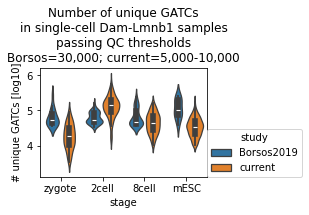

In [30]:
fig, ax = plt.subplots(figsize=(3,2))
sns.violinplot(
    x=to_plot['stage'], y=np.log10(to_plot['unique_damid_counts']), hue=to_plot['study'], 
    order = stage_order, ax=ax
)
ax.set_title('Number of unique GATCs\nin single-cell Dam-Lmnb1 samples\npassing QC thresholds\nBorsos=30,000; current=5,000-10,000')
ax.legend(loc=(1,0), title='study')
ax.set_ylabel('# unique GATCs [log10]')

outfn = FIGOUTDIR + 'Borsos2019_comparison.unique_GATCs.pdf'
plt.savefig(outfn, bbox_inches='tight')

__Statistical test: unique GATCs__

In [31]:
from collections import defaultdict

In [32]:
stat_df = defaultdict(list)

for stage in stage_order:
    
    ind = (to_plot.stage == stage)
    A = to_plot.loc[ind & (to_plot.study == 'Borsos2019'), 'unique_damid_counts'].values
    B = to_plot.loc[ind & (to_plot.study == 'current'), 'unique_damid_counts'].values
    result = stats.ranksums(A, B, alternative='two-sided')

    stat_df['stage'].append(stage)
    stat_df['sample_1'].append('Borsos2019')
    stat_df['sample_2'].append('current')
    stat_df['N_1'].append(len(A))
    stat_df['N_2'].append(len(B))
    stat_df['wilcox_stat'].append(result[0])
    stat_df['wilcox_pval'].append(result[1])
    stat_df['mean_1'].append(A.mean())
    stat_df['mean_2'].append(B.mean())
    stat_df['median_1'].append(np.median(A))
    stat_df['median_2'].append(np.median(B))
    stat_df['std_1'].append(np.std(A))
    stat_df['std_2'].append(np.std(B))
        
stat_df = pd.DataFrame(stat_df)

outfn = FIGOUTDIR + 'Borsos2019_comparison.unique_GATCs.statistical_test_results.tsv'
stat_df.to_csv(outfn, sep='\t', header=True, index=False)

## 4.3 Comparison of IC

In [33]:
to_plot = borsos_sub[borsos_sub.fusion_construct == 'Dam-LMNB1'].copy().rename(columns={'name': 'damid_name'})
cols = ['damid_name', 'stage', 'IC_mappability']
to_plot = to_plot[cols]
to_plot['study'] = 'Borsos2019'

ind0 = (anno.genotype == 'homozygous') | (anno.stage == 'mESC')
ind1 = (anno.cellcount == 1)
ind2 = anno.fusion_construct.isin(['Dam-Lmnb1']) & (anno.treatment == 'no_treatment')
tmp = anno[ind0&ind1&ind2].copy()

tmp = tmp.merge(thresholds)
ind_filt = (tmp.unique_damid_counts >= tmp.depth_threshold) & (tmp.allelic_damid_balance)
tmp = tmp[ind_filt] # ONLY FILTER ON DEPTH & ALLELIC BALANCE

tmp['stage'] = tmp['stage'].astype(str)
tmp = tmp[cols].reset_index(drop=True)
tmp['study'] = 'current'

to_plot = pd.concat([to_plot, tmp]).reset_index(drop=True)

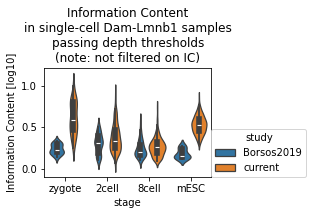

In [34]:
fig, ax = plt.subplots(figsize=(3,2))
sns.violinplot(
    x=to_plot['stage'], y=np.log10(to_plot['IC_mappability']), hue=to_plot['study'], 
    order = stage_order, ax=ax
)
ax.set_title('Information Content\nin single-cell Dam-Lmnb1 samples\npassing depth thresholds\n(note: not filtered on IC)')
ax.legend(loc=(1,0), title='study')
ax.set_ylabel('Information Content [log10]')

outfn = FIGOUTDIR + 'Borsos2019_comparison.information_content.pdf'
plt.savefig(outfn, bbox_inches='tight')

__Statistical test: Information Content__

In [35]:
stat_df = defaultdict(list)

for stage in stage_order:
    
    ind = (to_plot.stage == stage)
    A = to_plot.loc[ind & (to_plot.study == 'Borsos2019'), 'IC_mappability'].values
    B = to_plot.loc[ind & (to_plot.study == 'current'), 'IC_mappability'].values
    result = stats.ranksums(A, B, alternative='two-sided')

    stat_df['stage'].append(stage)
    stat_df['sample_1'].append('Borsos2019')
    stat_df['sample_2'].append('current')
    stat_df['N_1'].append(len(A))
    stat_df['N_2'].append(len(B))
    stat_df['wilcox_stat'].append(result[0])
    stat_df['wilcox_pval'].append(result[1])
    stat_df['mean_1'].append(A.mean())
    stat_df['mean_2'].append(B.mean())
    stat_df['median_1'].append(np.median(A))
    stat_df['median_2'].append(np.median(B))
    stat_df['std_1'].append(np.std(A))
    stat_df['std_2'].append(np.std(B))
        
stat_df = pd.DataFrame(stat_df)

outfn = FIGOUTDIR + 'Borsos2019_comparison.information_content.statistical_test_results.tsv'
stat_df.to_csv(outfn, sep='\t', header=True, index=False)